# 1. Load data

In [6]:
from src.dataloaders import FPathLazyDataset

mask_threshold = 0.99

train_dset = FPathLazyDataset(config_path="dataset/train3.yaml", mask_threshold=mask_threshold)
val_dset = FPathLazyDataset(config_path="dataset/val3.yaml", mask_threshold=mask_threshold)
test_dset = FPathLazyDataset(config_path="dataset/test3.yaml", mask_threshold=mask_threshold, test=True)

# 2. Visualize sample data

In [ ]:
data = train_dset[0]
vtf, img, infodraw, target, mask = data["vtf"], data["img"], data["infodraw"], data["target"], data["mask"]
print(f"vtf.shape: {vtf.shape}, img.shape: {img.shape}, infodraw.shape: {infodraw.shape}, target.shape: {target.shape}, mask.shape: {mask.shape}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

vtf_vis = np.repeat(np.mean(vtf, axis=0, keepdims=True), 3, axis=0)
img_vis = np.array(img)
infodraw_vis = np.repeat(infodraw, 3, axis=0)
target_vis = np.repeat(target, 3, axis=0)
mask_vis = np.repeat(mask, 3, axis=0)

samples = np.concatenate([vtf_vis, img_vis, infodraw_vis, target_vis, mask_vis], axis=2)
plt.figure(figsize=(25, 5))
plt.imshow(np.transpose(samples, (1, 2, 0)))
plt.axis("off")

# 3. Define a Model

In [4]:
device = "cuda:0"

In [5]:
import torch

from src.models import FCNet

In [6]:
model = FCNet()
model = model.to(device)
model = model.train()

In [ ]:
# input:  [B, 21, H, W]
# output: [B, 1 , H, W]

test_input = torch.rand(1, 21, 500, 400).to(device)
output = model(test_input)
print(output.shape)

# 4. Train

In [11]:
from torch.utils.data import DataLoader
from src.losses import MaskedBCELoss
import torch.optim as optim

train_dloader = DataLoader(dataset=train_dset, batch_size=16, shuffle=True, num_workers=24)
val_dloader = DataLoader(dataset=val_dset, batch_size=16, shuffle=False, num_workers=24)

criterion = MaskedBCELoss()
optimizer = optim.Adam(params=model.parameters(), lr=1e-3)

### define train & evaluation

In [12]:
from tqdm import tqdm

def train(train_dloader):
    model.train()
    losses = []
    for batch in tqdm(train_dloader):
        vtf, target, mask = batch["vtf"].to(device), batch["target"].to(device), batch["mask"].to(device)
        
        output = model(vtf)
        
        loss = criterion(output, target, mask)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return losses

def evaluate(val_dloader):
    model.eval()
    for batch in tqdm(val_dloader):
        vtf, target, mask = batch["vtf"].to(device), batch["target"].to(device), batch["mask"].to(device)
        
        output = model(vtf)
        
        output_bin = output > 0.5 # 0.5 이하는 검정 (sketch)
        
        truth_table = mask * (output_bin == target)
        accuracy = torch.sum(truth_table) / torch.sum(mask)
        
        return accuracy

## 4.1. Overfit on validataion set

In [11]:
# EPOCHS = 10

# for epoch in range(1, EPOCHS+1):
#     losses = train(val_dloader)
#     accuracy = evaluate(val_dloader)
    
#     print(f"epoch: {epoch:3d} || val loss: {np.mean(losses)}, val accuracy: {100 * accuracy}")

## 4.2. Full Training

In [ ]:
EPOCHS = 6 # 6에폭도 충분함.

for epoch in range(1, EPOCHS+1):
    losses = train(train_dloader)
    accuracy = evaluate(val_dloader)
    
    print(f"epoch: {epoch:3d} || train loss: {np.mean(losses)}, val accuracy: {100 * accuracy}")
    
torch.save(model.state_dict(), "train3_model.pth")

### Save trained model

In [18]:
# torch.save(model.state_dict(), "train3_model.pth")

# 5. Inference test image

### Load model

In [ ]:
model = FCNet()
model.load_state_dict(torch.load("weights/train3_model.pth"))
model = model.to(device)
model.eval()

In [ ]:
test_dloader = DataLoader(test_dset, batch_size=1, shuffle=False, num_workers=8)

batch = next(iter(test_dloader))

test_vtf, test_mask = batch["vtf"], batch["mask"]

test_vtf, test_mask = test_vtf.to(device), test_mask.to(device)

In [21]:
pred = model(test_vtf)

In [22]:
res = pred > 0.5

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(res.squeeze().detach().cpu().numpy())
plt.axis('off')

# 6. Enhance GT

In [1]:

from stick_to_sketch import get_enhanced_target

from src.preprocesses import VTFPreprocessor, InfodrawPreprocessor, TargetPreprocessor, FlowpathPreprocessor

from src.dataloaders import FPathLazyDataset

mask_threshold = 0.99

train_dset = FPathLazyDataset(config_path="dataset/train3.yaml", mask_threshold=mask_threshold)
val_dset = FPathLazyDataset(config_path="dataset/val3.yaml", mask_threshold=mask_threshold)
test_dset = FPathLazyDataset(config_path="dataset/test3.yaml", mask_threshold=mask_threshold, test=True)

import torch

from src.models import FCNet

device = "cuda:0"

model = FCNet()
model.load_state_dict(torch.load("weights/train3_model.pth"))
model = model.to(device)
model.eval()

FCNet(
  (layer1): Sequential(
    (0): Linear(in_features=21, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU(inplace=True)
  )
  (final_layer): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [2]:
data_path = test_dset.data[0]
vtf = VTFPreprocessor.get(data_path["vtf"])
infodraw = InfodrawPreprocessor.get(data_path["infodraw"])
target = TargetPreprocessor.get(data_path["target"])
flowpath = FlowpathPreprocessor.get(data_path["flowpath"])
print(f"vtf: {vtf.shape}, infodraw: {infodraw.shape}, target: {target.shape}, flowpath: {flowpath.shape}")

mask = infodraw < test_dset.mask_threshold

mask = mask.to(device)
vtf_tensor = torch.tensor(vtf).unsqueeze(0).to(device)
model = model.to(device)
enhanced_target = get_enhanced_target(
    predictor=model,
    vtf_tensor=vtf_tensor,
    infodraw=infodraw,
    target=target,
    flowpath=flowpath,
    mask=mask,
) 

vtf: (21, 1024, 1024), infodraw: torch.Size([1, 1024, 1024]), target: torch.Size([1, 1024, 1024]), flowpath: (1024, 1024, 21, 2)
1. init seed...
2. processing jump flooding algorithm...
[6, 427] 가 약 스케치에서 강 스케치로 전환됨.
[9, 338] 가 약 스케치에서 강 스케치로 전환됨.
[15, 320] 가 약 스케치에서 강 스케치로 전환됨.
[19, 342] 가 약 스케치에서 강 스케치로 전환됨.
[21, 343] 가 약 스케치에서 강 스케치로 전환됨.
[25, 316] 가 약 스케치에서 강 스케치로 전환됨.
[28, 384] 가 약 스케치에서 강 스케치로 전환됨.
[31, 967] 가 약 스케치에서 강 스케치로 전환됨.
[32, 966] 가 약 스케치에서 강 스케치로 전환됨.
[34, 964] 가 약 스케치에서 강 스케치로 전환됨.
[45, 308] 가 약 스케치에서 강 스케치로 전환됨.
[55, 304] 가 약 스케치에서 강 스케치로 전환됨.
[64, 299] 가 약 스케치에서 강 스케치로 전환됨.
[64, 917] 가 약 스케치에서 강 스케치로 전환됨.
[66, 935] 가 약 스케치에서 강 스케치로 전환됨.
[77, 63] 가 약 스케치에서 강 스케치로 전환됨.
[78, 76] 가 약 스케치에서 강 스케치로 전환됨.
[78, 110] 가 약 스케치에서 강 스케치로 전환됨.
[79, 75] 가 약 스케치에서 강 스케치로 전환됨.
[79, 111] 가 약 스케치에서 강 스케치로 전환됨.
[80, 374] 가 약 스케치에서 강 스케치로 전환됨.
[82, 383] 가 약 스케치에서 강 스케치로 전환됨.
[83, 383] 가 약 스케치에서 강 스케치로 전환됨.
[83, 493] 가 약 스케치에서 강 스케치로 전환됨.
[83, 494] 가 약 스케치에서 강 스케치로 전환됨.
[84, 383] 가 약 스케치에서

# 7. Result

(-0.5, 1023.5, 1023.5, -0.5)

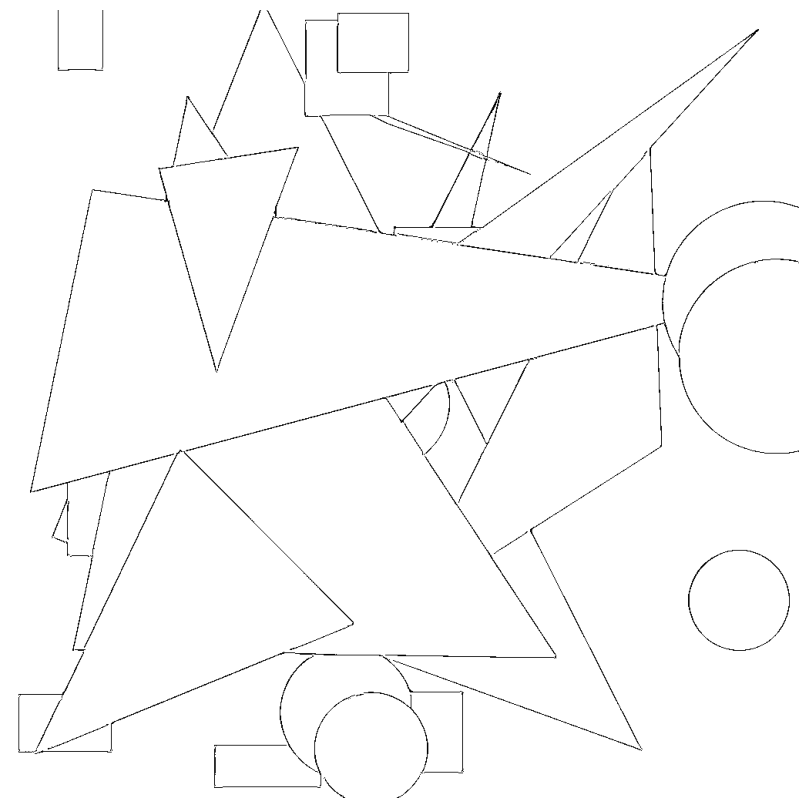

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10.24, 10.24))
plt.imshow(1-enhanced_target, vmin=0, vmax=1, cmap='gray')
plt.axis("off")